In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import sys

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj

from preprocess import *
from utils import *
from model import *
from train import *

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Dataset
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

torch.manual_seed(1)

# Train test split
train_split = 0.8
batch_size = 16
visual_batch_size = 200
train_loader, val_loader, test_loader, visual_data_loader = prepare_data(dataset, train_split, batch_size, visual_batch_size)


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Class split - Training 0: 1929 1: 1540, Validation 0: 238 1: 196, Test 0: 234 1: 200


### CEM Clustering Functions

In [12]:
from collections import Counter

def cem_cluster_dict(activation_space_before, graph_nodes_enumerate):
    relevant_features = []
    for idx, real_node_number in enumerate(graph_nodes_enumerate):
        # Extract the features for the relevant nodes in the graph
        relevant_features.append(activation_space_before[idx, real_node_number, :])
    # Concatenate all the relevant features along the first dimension
    features = torch.cat(relevant_features, dim=0)
    
    # CEM-clustering
    _, indices = cem_clustering(features)
    

    # Use Counter to count occurrences
    occurrences = Counter(indices.tolist())

    # Sort the occurrences dictionary by values
    sorted_occurrences = sorted(occurrences.items(), key=lambda x: x[1], reverse=True)

    # Optionally, convert back to dictionary if needed
    sorted_occurrences_dict = dict(sorted_occurrences)
    print(len(indices))
    print(sorted_occurrences_dict)

    return sorted_occurrences_dict

In [4]:
def cem_plot(activation_space_before, graph_nodes_enumerate, DR_method, layer_num):
    relevant_features = []
    for idx, real_node_number in enumerate(graph_nodes_enumerate):
        # Extract the features for the relevant nodes in the graph
        relevant_features.append(activation_space_before[idx, real_node_number, :])
    # Concatenate all the relevant features along the first dimension
    features = torch.cat(relevant_features, dim=0)
    
    # CEM-clustering
    num_unique_rows, indices = cem_clustering(features)

    # Convert to numpy for dimensionality reduction
    features_np = features.detach().cpu().numpy()

    # Apply Dimension Reduction
    features_DR = dimension_reduction(features_np, DR_method)

    # ========================== Plotting Activation Space ==========================
    colors0 = plt.cm.jet(np.linspace(0, 1, num_unique_rows))

    for i, label in enumerate(indices):
        plt.scatter(features_DR[i, 0], features_DR[i, 1], color=colors0[int(label)], label=f'Cluster {int(label)}')

    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space before {layer_num} (CEM colored with {num_unique_rows} clusters)')
    plt.show()  

## First Vanilla GNN for deciding the First DiffPool cluster number

In [3]:
# Define the model
num_hidden_unit = 40
model_vanilla = Vanilla_GNN(dataset.num_features, num_hidden_unit, dataset.num_classes)
model_checkpoint_vanilla = f'vanilla_model_state_dict_best_{num_hidden_unit}.pth'
model_type = 'vanilla'

# Training
lr = 0.001
epochs = 100
experiment_runner(model_vanilla, train_loader, val_loader, lr, epochs, model_checkpoint_vanilla, True, model_type)

Epoch 1, Train Loss: 0.5997, Val Loss: 0.5398, Val Acc: 0.7350
Epoch 2, Train Loss: 0.5609, Val Loss: 0.5809, Val Acc: 0.7051
Epoch 3, Train Loss: 0.5350, Val Loss: 0.5198, Val Acc: 0.7373
Epoch 4, Train Loss: 0.5281, Val Loss: 0.5489, Val Acc: 0.7235
Epoch 5, Train Loss: 0.5182, Val Loss: 0.5210, Val Acc: 0.7535
Epoch 6, Train Loss: 0.5120, Val Loss: 0.5160, Val Acc: 0.7465
Epoch 7, Train Loss: 0.5050, Val Loss: 0.6014, Val Acc: 0.6728
Epoch 8, Train Loss: 0.5011, Val Loss: 0.5241, Val Acc: 0.7535
Epoch 9, Train Loss: 0.4965, Val Loss: 0.5320, Val Acc: 0.7074
Epoch 10, Train Loss: 0.4899, Val Loss: 0.5265, Val Acc: 0.7396
Epoch 11, Train Loss: 0.4883, Val Loss: 0.5114, Val Acc: 0.7558
Epoch 12, Train Loss: 0.4825, Val Loss: 0.5304, Val Acc: 0.7673
Epoch 13, Train Loss: 0.4790, Val Loss: 0.5375, Val Acc: 0.7535
Epoch 14, Train Loss: 0.4705, Val Loss: 0.6478, Val Acc: 0.7558
Epoch 15, Train Loss: 0.4724, Val Loss: 0.5125, Val Acc: 0.7696
Epoch 16, Train Loss: 0.4703, Val Loss: 0.5106, V

In [16]:
model_vanilla0 = Vanilla_GNN(dataset.num_features, num_hidden_unit, dataset.num_classes)
model_vanilla0.load_state_dict(torch.load(f'vanilla_model_state_dict_best_{num_hidden_unit}.pth'))
model_vanilla0.eval() 
model_type = 'vanilla'

criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = test(model_vanilla0, visual_data_loader, criterion, model_type)
print('Test Accuracy on Visual Data Loader:', test_acc)

Test Accuracy on Visual Data Loader: 0.7442396313364056


In [17]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)

    y_labels = data.y.tolist()
    
    graph_nodes = real_graph_node(data)
    
    out, x_gnn1_embed = model_vanilla0(batched_x, adj)
    
    break

In [19]:
graph_nodes_enumerate = [list(range(n)) for n in graph_nodes]
sorted_cluster_dict = cem_cluster_dict(x_gnn1_embed, graph_nodes_enumerate)

6197
{388: 429, 344: 415, 1: 296, 31: 186, 167: 162, 374: 143, 16: 131, 54: 128, 5: 126, 229: 110, 201: 108, 373: 102, 29: 88, 70: 87, 458: 87, 66: 83, 198: 77, 211: 76, 234: 74, 82: 73, 441: 72, 144: 66, 332: 63, 378: 61, 459: 57, 449: 55, 163: 52, 30: 51, 149: 50, 435: 48, 271: 47, 165: 42, 196: 42, 108: 40, 233: 40, 58: 39, 357: 38, 377: 36, 186: 36, 185: 36, 33: 34, 461: 33, 199: 31, 79: 29, 353: 29, 439: 28, 236: 28, 366: 26, 96: 26, 418: 26, 47: 25, 241: 24, 450: 24, 266: 24, 391: 23, 34: 23, 181: 22, 240: 22, 318: 21, 67: 21, 457: 21, 148: 21, 2: 21, 81: 20, 434: 20, 152: 20, 80: 20, 166: 20, 277: 19, 267: 19, 285: 19, 303: 19, 265: 19, 358: 18, 329: 18, 180: 17, 44: 17, 417: 17, 367: 17, 4: 16, 169: 16, 182: 16, 21: 15, 279: 15, 392: 14, 257: 14, 3: 14, 448: 13, 136: 13, 153: 13, 389: 13, 106: 13, 356: 12, 299: 12, 18: 12, 60: 12, 143: 12, 159: 12, 355: 12, 452: 11, 298: 11, 347: 11, 321: 11, 160: 11, 320: 11, 260: 10, 116: 10, 286: 10, 157: 10, 179: 10, 151: 10, 176: 10, 440: 

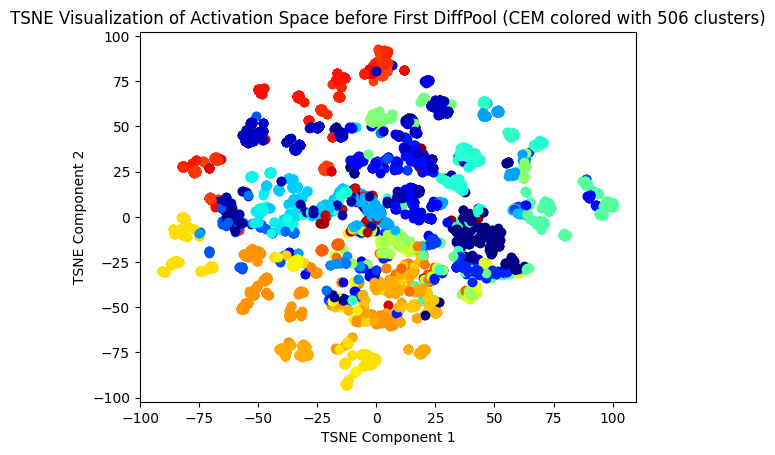

In [13]:
cem_plot(x_gnn1_embed, graph_nodes_enumerate, 'TSNE', 'First DiffPool')

## Second Vanilla GNN for deciding the Second DiffPool cluster number

Epoch 1, Train Loss: 2.5597, Val Loss: 0.6001, Val Acc: 0.7074
Epoch 2, Train Loss: 2.1797, Val Loss: 0.5699, Val Acc: 0.7419
Epoch 3, Train Loss: 1.9291, Val Loss: 0.6214, Val Acc: 0.6705
Epoch 4, Train Loss: 1.7526, Val Loss: 0.6032, Val Acc: 0.7051
Epoch 5, Train Loss: 1.6177, Val Loss: 0.5190, Val Acc: 0.7558
Epoch 6, Train Loss: 1.4451, Val Loss: 0.6367, Val Acc: 0.6636
Epoch 7, Train Loss: 1.2622, Val Loss: 0.6124, Val Acc: 0.7005
Epoch 8, Train Loss: 0.9719, Val Loss: 0.5110, Val Acc: 0.7627
Epoch 9, Train Loss: 0.8222, Val Loss: 0.5561, Val Acc: 0.7673
Epoch 10, Train Loss: 0.7435, Val Loss: 0.5257, Val Acc: 0.7627
Epoch 11, Train Loss: 0.7088, Val Loss: 0.5039, Val Acc: 0.7558
Epoch 12, Train Loss: 0.6728, Val Loss: 0.5183, Val Acc: 0.7558
Epoch 13, Train Loss: 0.6317, Val Loss: 0.4939, Val Acc: 0.7696
Epoch 14, Train Loss: 0.6189, Val Loss: 0.5163, Val Acc: 0.7742
Epoch 15, Train Loss: 0.5980, Val Loss: 0.5548, Val Acc: 0.7258
Epoch 16, Train Loss: 0.5774, Val Loss: 0.5347, V

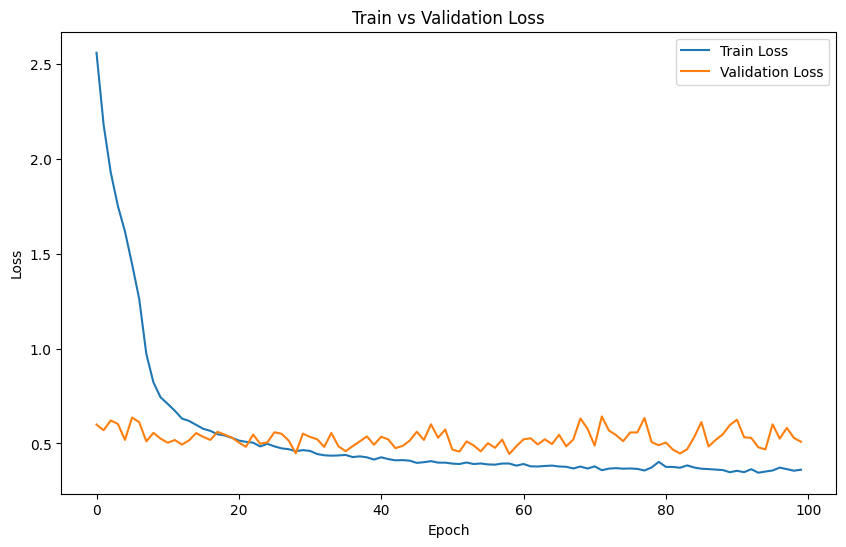

In [6]:
# Define the model
num_hidden_unit = 40
num_nodes1 = 12
model_vanilla2 = Vanilla_GNN2(dataset.num_features, num_hidden_unit, dataset.num_classes, num_nodes1)
model_checkpoint_vanilla2 = f'vanilla_model_hidden_unit_{num_hidden_unit}_diffpool_{num_nodes1}.pth'
model_type2 = 'vanilla2'

# Training
lr = 0.001
epochs = 100
experiment_runner(model_vanilla2, train_loader, val_loader, lr, epochs, model_checkpoint_vanilla2, True, model_type2)

In [20]:
model_vanilla2_0 = Vanilla_GNN2(dataset.num_features, num_hidden_unit, dataset.num_classes, num_nodes1)
model_vanilla2_0.load_state_dict(torch.load(model_checkpoint_vanilla2))
model_vanilla2_0.eval() 

criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = test(model_vanilla2_0, visual_data_loader, criterion, model_type2)
print('Test Accuracy on Visual Data Loader:', test_acc)

Test Accuracy on Visual Data Loader: 0.8294930875576036


In [21]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)

    y_labels = data.y.tolist()
    
    graph_nodes = real_graph_node(data)
    
    out, _, _, x_gnn2_embed, cluster_assignments1 = model_vanilla2_0(batched_x, adj)
    
    break

In [22]:
graph_nodes_enumerate_2 = []
for batch_idx in range(len(cluster_assignments1)):
    new_nodes = cluster_assignments1[batch_idx][:graph_nodes[batch_idx]]
    graph_nodes_enumerate_2.append(torch.unique(new_nodes).tolist())

sorted_cluster_dict_2 = cem_cluster_dict(x_gnn2_embed, graph_nodes_enumerate_2)

894
{256: 43, 281: 25, 126: 22, 6: 22, 37: 19, 33: 17, 15: 15, 52: 14, 216: 13, 136: 12, 277: 10, 247: 9, 4: 9, 78: 8, 258: 8, 245: 8, 131: 8, 127: 7, 2: 7, 155: 7, 178: 7, 105: 7, 48: 6, 116: 6, 0: 6, 128: 5, 244: 5, 20: 5, 209: 5, 21: 5, 260: 5, 180: 5, 118: 4, 283: 4, 263: 4, 16: 4, 246: 4, 313: 4, 139: 4, 211: 4, 243: 4, 181: 4, 22: 4, 419: 3, 23: 3, 70: 3, 55: 3, 259: 3, 279: 3, 143: 3, 59: 3, 29: 3, 207: 3, 61: 3, 85: 3, 210: 3, 8: 3, 320: 3, 112: 3, 220: 3, 100: 2, 282: 2, 231: 2, 228: 2, 264: 2, 10: 2, 103: 2, 35: 2, 381: 2, 41: 2, 114: 2, 154: 2, 400: 2, 424: 2, 137: 2, 119: 2, 157: 2, 151: 2, 38: 2, 414: 2, 391: 2, 162: 2, 161: 2, 206: 2, 385: 2, 387: 2, 257: 2, 97: 2, 73: 2, 350: 2, 291: 2, 379: 2, 44: 2, 53: 2, 275: 2, 150: 2, 219: 2, 314: 2, 215: 2, 140: 2, 141: 2, 443: 2, 268: 2, 133: 2, 267: 2, 395: 2, 376: 2, 322: 2, 34: 2, 74: 2, 91: 2, 94: 2, 342: 2, 43: 2, 370: 2, 319: 2, 57: 2, 67: 2, 109: 2, 101: 1, 172: 1, 163: 1, 425: 1, 420: 1, 24: 1, 54: 1, 388: 1, 377: 1, 72: 

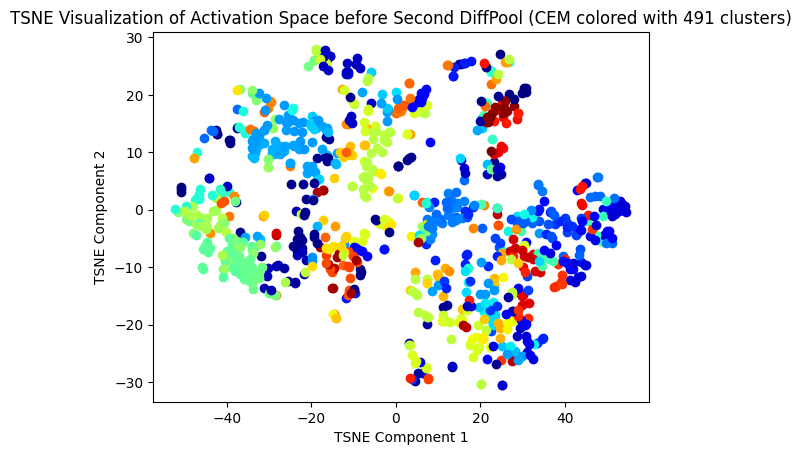

In [10]:
cem_plot(x_gnn2_embed, graph_nodes_enumerate_2, 'TSNE', 'Second DiffPool')